
# Dotazování v jazyce Cypher 

## Co se v této části naučíte

* strukturu základních dotazů v Cypher
* komplexnější dotazy využívající sekce OPTONAL MATCH a WITH
* dotazy s využitím pomocných (dočasných) vlastnosí
* využití knihovny vysokoúrovňové knihovny `py2neo`


## Základní dotazy

Stejně jako v případě SQL je klíčovou funkcí jazyka dotazování, tj. získávání dat z databáze. Zatímco v případě SQL je výsledkem vždy tabulka (skalár můžeme interpretovat jako tabulku 1×1) mohou být výsledky dotazování rozmanitější. V zásadě jsou následujích typů: 

* tabulka 
* podmnožina hran
* podmnožina uzlů 
* cesta

Ve všech těchto případech je výsledek primárně representován JSON dokumentem, V případě browseru mohou být některé z výsledků vizualizovány přehledněji (podgraf, tabulka).

Základní struktura dotazu je:
    
```
MATCH vzory
[WHERE filtr]
RETURN projekce
```

kde WHERE je nepovinné a hraje roli strážních podmínek v jazyce s unifikací vzorů (pattern matching).

Příklad:
```cypher
MATCH (p:Male) WHERE left(p.name,1)="R" 
RETURN p.name
```

dotaz vrací tabulku s jedním sloupcem, která zahrnuje jména všech mužů v databázi, jejichž jméno začíná písmenem "R




```cypher
MATCH (m:Male) RETURN m
```
vrací všechny uzly s popiskem `Male` (muže).

Test však lze přesunout do sekce `WHERE`:

```cypher
MATCH (m) WHERE m:Male RETURN m
```

v případě komplexnějších podmínek je však ale nutné použít sekci `WHERE`. Například pokud chceme zobrazit všechny uzly mužů a žen je nutno psát.

```cypher
MATCH (p) WHERE p:Male OR p:Female RETURN p
```

Tento dotaz vrátí 52 uzlů, tvořících podgraf, jehož grafickou podobu nabídne browser (zahrnuje do něj i vztahy mezi nalezenými uzly).

![výsledek dotazu](graf1.png)

Interní je však repesentace pomocí JSON struktury:

```json
{
    "p": {
"identity": 0,
"labels": [
        "Male"
      ],
"properties": {
"name": "Karel IV.",
"id": 1
      }
    }
  },
  {
    "p": {
"identity": 1,
"labels": [
        "Male"
      ],
"properties": {
"name": "Jan Lucemburský",
"id": 2
      }
    }
  },
  {
    "p": {
"identity": 2,
"labels": [
        "Female"
      ],
"properties": {
"name": "Eliška Přemyslovna",
"id": 3
      }
    }
  }, ...
```

## Využití cest v dotazech

Skutečná síla Cypher dotazů však leží ve využití cest tj. posloupnosti uzlů a vztahů. Pro příklad uveďme dotaz na jména všech předků Karla IV., kteří vládli Čechám.

```cypher
MATCH ({name:"Karel IV."}) -[:FATHER|MOTHER*]-> (p) -[:RULES]-> (t:Territory) 
WHERE t.name = "Čechy" 
RETURN p.name
```

sekce `MATCH` začíná kotevním/počátečním bodem tj. uzlem, jehož vlastnost `name` je Karel IV. (to není úplně košer. lepší by bylo `(:Male {name:"Karel IV."})` (ale zde nehrozí, že by stejné jméno měla žena nebo dokonce teritorium). Z tohoto uzlu musí vést cesta přes libovolný počet vztahů `MOTHER` nebo `FATHER` do cílových uzlů (budou odkazovány symbolem `p`). Tyto uzly tedy representují všechny předky (samozřejmě jen ty co máme v databázi). Z těchto uzlů zároveň musí vycházet vztah `RULES` mířící do uzlu representujícího Čechy (v `MATCH` je pouze podmínka, že míří do nějakého teritoria, omezení na Čechy přináší sekce `WHERE`).

Výsledkem je následující tabulka:

```
╒════════════════════╕
│"p.name"            │
╞════════════════════╡
│"Vladislav I."      │
├────────────────────┤
│"Vratislav II."     │
├────────────────────┤
│"Břetislav I."      │
├────────────────────┤
│"Vladislav II"      │
├────────────────────┤
│"Přemysl Otakar I." │
├────────────────────┤
│"Václav I."         │
├────────────────────┤
│"Přemysl Otakar II."│
├────────────────────┤
│"Václav II."        │
├────────────────────┤
│"Jan Lucemburský"   │
└────────────────────┘
```

Výsledek lze samozřejmě i třídit.

```cypher
MATCH (s {name:"Karel IV."}) -[:FATHER|MOTHER*]-> (p) -[:RULES]-> (t:Territory)  
   WHERE t.name = "Čechy"
   RETURN p.name 
   ORDER BY p.name
```

Jak ale ukazuje má řazení českých znaků k dokonalosti daleko.

```
╒════════════════════╕
│"p.name"            │
╞════════════════════╡
│"Břetislav I."      │
├────────────────────┤
│"Jan Lucemburský"   │
├────────────────────┤
│"Přemysl Otakar I." │
├────────────────────┤
│"Přemysl Otakar II."│
├────────────────────┤
│"Vladislav I."      │
├────────────────────┤
│"Vladislav II"      │
├────────────────────┤
│"Vratislav II."     │
├────────────────────┤
│"Václav I."         │
├────────────────────┤
│"Václav II."        │
└────────────────────┘
```

> **Úkol**: Vytvořte dotaz, který najde všechy, ženy u nichž známe alespoň jednoho dědečka.

Dotaz: TUFUQ0ggKGY6RmVtYWxlKS1bOkZBVEhFUnw6TUFUSEVSXS0+KCktWzpGQVRIRVJdLT4oKSBSRVRVUk4gZg==

V dotazech lze využívat i seskupování a to prostřednictvím standardní klauzule `RETURN`. Lze tak například zjistit, čemu vládli jednotliví mužové.

```cypher
MATCH (m:Male)-[:RULES]->(n) RETURN m, collect(n.name)
```

Funkce `collect` spojuje všechny vázané hodnoty do jednotlivého pole.

Výsledkem je následující seznam:

```
╒═════════════════════════════════════════════╤═════════════════════════════╕
│"m"                                          │"collect(n.name)"            │
╞═════════════════════════════════════════════╪═════════════════════════════╡
│{"name":"Karel IV.","id":1}                  │["SŘŘ","Lucembursko","Čechy"]│
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Jan Lucemburský","id":2}            │["Lucembursko","Čechy"]      │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Jindřich VII. Lucemburský","id":4}  │["SŘŘ","Lucembursko"]        │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Václav II.","id":6}                 │["Čechy"]                    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Jindřich VI. Lucemburský","id":8}   │["Lucembursko"]              │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Jan I. Brabantský","id":10}         │["Limburg","Brabantsko"]     │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Přemysl Otakar II.","id":12}        │["Rakousko","Čechy"]         │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Rudolf I. Habsburský","id":14}      │["Rakousko","SŘŘ"]           │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Jindřich V. Lucemburský","id":16}   │["Lucembursko"]              │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Přemysl Otakar I.","id":48}         │["Čechy"]                    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Vladislav II","id":96}              │["Čechy"]                    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Jindřich III. Brabantský","id":20}  │["Lotrinsko","Brabantsko"]   │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Vít z Dampierre","id":22}           │["Namur","Flandry"]          │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Václav IV.","id":114}               │["SŘŘ","Čechy"]              │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Václav I.","id":24}                 │["Čechy"]                    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Rostislav Haličský","id":26}        │["Slavonsko"]                │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Zikmud Lucemburský","id":124}       │["Uhry","SŘŘ","Čechy"]       │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Jan Zhořelecký","id":126}           │["Braniborsko"]              │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Albrecht IV. Habsburský","id":28}   │["Horní Alsasko","Aargau"]   │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Walram III. Limburský","id":32}     │["Limburg","Lucembursko"]    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Vladislav I.","id":200}             │["Čechy"]                    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Vratislav II.","id":202}            │["Čechy"]                    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Břetislav I.","id":204}             │["Čechy"]                    │
├─────────────────────────────────────────────┼─────────────────────────────┤
│{"name":"Václav Lucemburský","id":300}       │["Lucembursko"]              │
└─────────────────────────────────────────────┴─────────────────────────────┘
```

Jak lze vidět tak většina mužských předků vládla alespoň jedné zemi. Existují však i předci, kteří se museli spokojit se šlechtictvím. Dotaz nám to neřekne, neboť `MATCH` vrací jen ty cesty, které úplně odpovídají vzoru.

Cypher však podporuje jen i klauzuli `OPTIONAL MATCH`, která uspěje i když se s ničím neshoduje a v tomto případě vrací prázdný seznam či null. Použitím odpovídá operátoru *outer join* z SQL.

```cypher
MATCH (m:Male) 
OPTIONAL MATCH (m)-[:RULES]->(n) 
RETURN m,collect(n.name)
```

Z výsledku je zřejmé, že v naší geneologické databázi existují dva nezeměpanští muži. Zkusíme si vypsat jejich jména.

```cypher
MATCH (m:Male) 
OPTIONAL MATCH (m)-[:RULES]->(n) 
  WITH m,collect(n.name) AS ts 
  WHERE size(ts) = 0 
  RETURN m.name
```

```
╒════════════════════════════╕
│"m.name"                    │
╞════════════════════════════╡
│"Balduin z Avesnes"         │
├────────────────────────────┤
│"Burkhard III. z Hohenbergu"│
└────────────────────────────┘
```

Novinkou je zde využití klauzule `WITH`. Ta má v tomto případě funkci podobnou `RETURN`. Místo vracení výsledku (= obdoba SQL selekce) však jen vytváří proměnné pro další fázi zpracování (tj. zároveň slouží jako zdroj tj. je to obdoba `MATCH`). Obdobou je klauzule `into` v Linq.

**Úkol**: Spočítejte průměrný počet zemí, jenž ovládá muž z naší databáze (se započtením i těch, co neovládají žádnou).

Výsledek: 1,46 (to není špatné a to jsem uváděl jen některé).

Dotaz: TUFUQ0ggKG06TWFsZSkgT1BUSU9OQUwgTUFUQ0ggKG0pLVs6UlVMRVNdLT4obikgV0lUSCBtLGNvbGxlY3Qobi5uYW1lKSBhcyB0cyBSRVRVUk4gYXZnKHNpemUodHMpKQ==

Výsledky dotazů mohou být i cesty. To lze využít například pro zjišťování minimální vzdálenosti, tj. v našem příkladě vzdáleností v pokrevní linii. Tato vzdálenost je 1 pro rodiče dané osoby stejně jako pro její děti (2 pro prarodiče, vnuky a sourozence). 

Dotaz má následující tvar:

```cypher
MATCH path=(:Male {name:"Karel IV."}) -[:FATHER|MOTHER*1..9]- (n) 
   WITH  n, length(path) as lpath 
   RETURN n.name, min(lpath) as mlpath 
   ORDER BY  mlpath
```

V sekci `MATCH` najdeme všechny cesty od Karla IV do ostatních uzlů representující osoby (to nemusíme explicite uvádět, neboť jen ty jsou dosažitelné vztahem matka a otec). 

Všimněte si dvou nových konstrukcí. Za prvé vztahy jsou nyní procházeny v obou směrech (vzor má podobu `-[]-` nikoliv `-[]->`)  a za druhé zápis `*1..9` označuje, že v cestě musí být 1 až devět hran (vztahů).

> **Poznámka**: v terminologii teorie grafů se jedná o **tah** tj. mohou se v něm opakovat uzly ale nikoliv hrany, zde využívám terminologii *Cypheru*

Konstrukce MATCH tak nejde všechny všechny cesty (tahy) o délce 1 až 9 začínající ve startovním uzlu a tyto cesty označí identifikátorem `path` (koncové uzly pak identifikátorem `n`). 

V klazuli `WITH` se pak vyprodukují dvojice koncový uzel a délka cesty (pro každou cestu ke každému uzlu). V sekci `RETURN` se pak provede seskupení podle koncového uzlu, pro nějž se najde nejkratší délka.

> **Otázka:** V Cypher neexistuje obdoba konstrukce `GROUP BY`. Co ji nahrazuje?

Poslední klazule setřídí uzly podle délky minimálních cest (vzestupně).

Výsledek (vyzkoušejte) odpovídá očekávání. Je zde však jeden problém -- i když je graf relativně jednoduchý a obahuje jen málo (neorientovaných) cyklů je počet existujících tahů do každého z uzlů překvapivě vysoký (jednotlivé cykly se dají různě kombinovat).  

Počet tahů pro jejich různé délky ukazuje následující graf. Je zřejmé, že je shora omezen (na rozdíl od počtu sledů), ale pro delší tahy je přes 200 000.

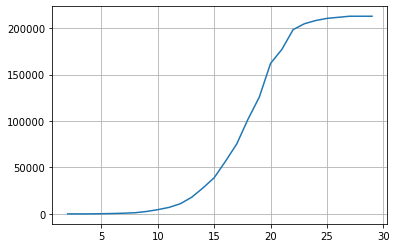

In [2]:
import matplotlib.pyplot as plt

x = range(2, 30)
y = [24, 50, 88, 244, 470, 795, 1310, 2656, 4609, 7058, 11010, 17954, 27954, 38978, 56642, 75330, 
     101954, 125698, 161986, 176962, 198274, 204610, 208066, 210370, 211522, 212674, 212674, 212674]
plt.plot(x, y)
plt.grid(True)

> **Úkol**: Jakým dotazem lze zjistit počet cest?

Dotaz: TUFUQ0ggKG06TWFsZSkgT1BUSU9OQUwgTUFUQ0ggKG0pLVs6UlVMRVNdLT4obikgV0lUSCBtLGNvbGxlY3Qobi5uYW1lKSBhcyB0cyBSRVRVUk4gYXZnKHNpemUodHMpKQ==

Z tohoto důvodu je vyhledávání omezeno na cesty délky maximálně 9 (což je vzdálenost k nejvzdálenějšímu pokrevnímu příbuznému v našem grafu). Toto řešení však příliš nepomůže u složitějších grafů (tj. např. pokud bychom do našeho grafu přidali i další potomky předků).

Proto je nutné zvolit jiné řešení. Nejdříve se však podíváme na další klíčový mechanismus.

## Nastavování atributů na základě komplexnějších dotazů

Nastavení dočasných atributů lze využít pro ukládání výsledků dotazů přímo v grafu. Příkladem je např. dotaz na všechny sourozence Karla IV.

```cypher
MATCH ({name: "Václav IV."}) -[:FATHER|MOTHER]-> () <-[:FATHER|MOTHER]- (s) 
RETURN s
```

Výsledek dotazu můžeme využít pro nastavení atributu `relation` u nalezených uzlů.

```cypher
MATCH ({name: "Václav IV."}) -[:FATHER|MOTHER]-> () <-[:FATHER|MOTHER]- (s) 
SET s.relation="sibling"
```

Nyní lze pro nalezení sourozenců použít jednodušší dotaz:

```cypher
MATCH (n) WHERE n.relation = "sibling"
RETURN n 
```

A především lze využít dotaz využít jako východisko dalších dotazů.

```cypher
MATCH (v {name:"Václav IV."}), (v) -[:FATHER]-> () <-[:FATHER]- (fs),  (v) -[:MOTHER]-> () <-[:MOTHER]- (ms) 
WHERE fs = ms 
RETURN fs
```

> **Otázka**: Co je výsledkem dotazu?

Nyní již jistě víte, jak dosáhnout efektivnějšího zjištění stupně přímého příbuzenství. K tomu však potřebujeme postupné provedení několika modifikujících dotazů. Cypher je však deklarativní jazyk a tudíž v něm nelze (stejně jako v SQL) zajistit postupné volání několika modifikujích dotazů v cyklu. Konstrukce `FOREACH` resp. `UNWIND` umožňuje provedení několika dotazů s různými hodnotami, ale ty se vykonávájí všechny najednou tj. jako by byly vykonány paralelně (pro skutečný paralelismus je nutný distribuovaný systém, ale výsledek na tom nezávisí).

> **Úkol**: Prostudujte konstrukce `FOREACH` a `UNWIND` (https://neo4j.com/docs/cypher-manual/current/) a jejich použití. Čím se liší a co mají společné?

Proto musíme využít nějakou procedurální nadstavbu Cypheru. Z více možností zvolíme možnost aktivace Cypher dotazů z Pythonu.

## Python a Neo4j


Python je primárně podporován tzv. ovladačem `neo4j-driver`, což je nízkoúrovňový modul, který zajištuje komunikaci s DBMS. Při využití ovladače je kód blízký kódu v jiných jazycích (primární jazyk je Java).

Pro snadnější a více pythonické rozhraní je  možno použít nadstavbových knihoven. Zde budeme využívat modul `py2neo`, který podporuje i nejnovější verze databázového systému.

Modul podporuje snadné vykonávání Cypher příkazů, mapuje Cypher objekty do pythonských.

In [19]:
from py2neo import Graph

g = Graph("bolt://localhost:7687", auth=("neo4j", "test"), name="neo4j") #| připojení a vytvoření objektu 
c = g.run("MATCH (n:Male) WHERE left(n.name, 1)='V' RETURN n")
for record in c:
    print(record)

Node('Male', id=6, name='Václav II.')
Node('Male', id=96, name='Vladislav II')
Node('Male', id=22, name='Vít z Dampierre')
Node('Male', id=114, name='Václav IV.')
Node('Male', id=24, name='Václav I.')
Node('Male', id=200, name='Vladislav I.')
Node('Male', id=202, name='Vratislav II.')
Node('Male', id=300, name='Václav Lucemburský')


Kontruktor třídy `Graph` vytváří objekt zapouzdřující databázi se jménem `name` na serveru určeném URL, kde uživatele a heslo určuje parametr `auth`.

Metoda `run` provede Cypher příkaz a vrátí kurzor. Ten jen iterovatelný a jednotlivé iterace tvoří záznamy.

In [18]:
for record in g.run("MATCH () -[r:FATHER]-> (m) RETURN m, r"):
    print(record[1].end_node["name"])

Jan Lucemburský
Jindřich VII. Lucemburský
Václav II.
Jindřich VI. Lucemburský
Jan I. Brabantský
Přemysl Otakar II.
Rudolf I. Habsburský
Jindřich V. Lucemburský
Balduin z Avesnes
Jindřich III. Brabantský
Vít z Dampierre
Václav I.
Rostislav Haličský
Albrecht IV. Habsburský
Burkhard III. z Hohenbergu
Walram III. Limburský
Vladislav II
Vladislav I.
Karel IV.
Karel IV.
Karel IV.
Karel IV.
Přemysl Otakar I.
Karel IV.
Karel IV.
Karel IV.
Karel IV.
Vratislav II.
Břetislav I.
Jan Lucemburský


> **Otázka**: Co vrátil Cypher příkaz (tj. co representuje každý záznam). Co bylo ze záznamu extrahováno a jak? 

Kromě metody `run` lze vyžít u metodu `update` pokud není očekán žádná výstup resp. `evaluate`, pokud ve výstupu očekáváme jeden skalár.

Nyní už můžeme implementovat efektivnější algoritmus pro získání délky minimální cesty mezi uzly.
Nejdříve u všech uzlů vytvoříme vlastnost `distance`, která bude mít hodnotu -1 (značí dosud nenavštívený uzel). Pak u startovního uzlu změníme tuto distanci na nulu.

In [23]:
g.update("MATCH (s) WHERE s:Male or s:Female SET s.distance=-1")
g.update("MATCH (s {name: 'Karel IV.'}) SET s.distance=0")


Nyní budeme v cyklu postupně označovat uzly se vzdáleností 1 (= sousedé počátečního), 2, atd. Skončíme až nezbudou žádné neoznačené uzly (tj. uzly s `distance`=-1). Jádrem je nalezení (`MATCH`) uzlů, do nichž vedou hrany `FATHER` nebo `MOTHER` z uzlů s danou vzdálenost. Ty pak získají vzdálenost o jedničku vyšší.

In [27]:
dist = 0
while s:=g.evaluate("MATCH (n {distance:-1}) RETURN count(n)"):
    print(s)
    g.update(f"MATCH (m {{distance: {dist}}}) -[:FATHER|MOTHER]-  (n {{distance:-1}}) SET n.distance=m.distance + 1")
    dist +=1


51
41
33
25
9
5
3
2
1


Nakonec vypíšeme výsledek (pro přehlednost jej převedeme do pandas datarámce).

In [32]:
import pandas as pd

result = g.run("MATCH (m) WHERE exists(m.distance) RETURN m.name, m.distance ORDER BY m.distance, m.name")
pd.DataFrame(result, columns =['Name', 'Distance'])


,Name,Distance
0,Karel IV.,0
1,Alžběta Lucemburská,1
2,Anna Lucemburská,1
3,Eliška Přemyslovna,1
4,Jan Lucemburský,1
5,Jan Zhořelecký,1
6,Kateřina Lucemburská,1
7,Markéta Lucemburská,1
8,Markéta Lucemburská,1
9,Václav IV.,1


> **Úkol**: Výše uvedený algoritmus funguje jen pro souvislé grafy. Pozměňte ho tak, aby toto omezení neměl.

### Programové vytváření grafu

Programové vytváření grafu si ukážeme na ukládání hierarchického souboru, jenž je vytvářen příkazem `lshw --json`  (samozřejmě v Linuxu, používání jiného OS si nedovedu představit)

Tento JSON soubor má jednoduchou strukturu, každé zařízení je určeno několika atributy a podřízená zařízení jsou soustředěna v poli se jménem `children`.

Klíčovou roli při vytváření hraje objekt representujíci transakci (proměnná `tx`). Je vytvořen voláním metody `begin` nad objektem grafu. Uzly a vztahy se přidávají metodou `create`. A no konci je nutno zavolat metodu `commit` (jinak se změny neprojeví).

In [44]:
import json
from py2neo import Node, Relationship

def process_device(tree, parentNode, tx):
    id = tree["id"] # jedinečné id zařízení
    cls = tree["class"] # třída zařízení
    desc = f"{tree.get('description','')}:{tree.get('product','')}" # jméno zařízení (ne zcela obecné řešení)
    capacity = int(tree.get("capacity", 0)) # kapacita zařízení v bytech
    
    # creation of node
    node = Node(cls, desc=desc, capacity=capacity) # popisek třídy zařízení
    node.add_label("device") # společný popisek
    tx.create(node)
    
    # creation of Relationship
    if parentNode:
        rs = Relationship(node, "PARENT", parentNode)
        tx.create(rs)
    
    if "children" in tree:
        for child in tree["children"]:
            process_device(child, node, tx)
        
with open("lshw") as f:
    tree = json.load(f)
    tx =  g.begin() # create context (= )
    process_device(tree[0], None, tx)
    tx.commit()

/tmp/ipykernel_607863/82559395.py:28: DeprecationWarning: The transaction.commit() method is deprecated, use graph.commit(transaction) instead
  tx.commit()


> **Úkol**: Vytvořte graf s pomocí JSON souboru vytvořeného ve vašem OS (okud nemáte Linux požádejte o výpis nějakého z vašich šťastnějších přátel). Zkuste provést několik dotazů, např. celkovou velikost svazků, 